In [1]:
import tensorflow as tf
from tensorflow.contrib import predictor

export_dir = "gs://neural-guidance-tensorflow/export/0314_michal_series4_sr50_attention_l40/1552640099/"
predict_fn = predictor.from_saved_model(export_dir)

INFO:tensorflow:Restoring parameters from gs://neural-guidance-tensorflow/export/0314_michal_series4_sr50_attention_l40/1552640099/variables/variables


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [3]:
import sys 
sys.path.insert(0,'..')

In [4]:
from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [5]:
LIMIT_RUNS = 1000

In [6]:
def shorten_cnf(cnf: CNF):
    for c in cnf.clauses:
        if len(c) == 1:
            # print("Chosen lone clause", c[0])
            return shorten_cnf(cnf.set_var(c[0]))
    all_literals = set(x
                       for clause in cnf.clauses
                       for x in clause)
    for v in cnf.vars:
        if v in all_literals and (-v) not in all_literals:
            # print("Chosen lone literal", v)
            return shorten_cnf(cnf.set_var(v))
        if (-v) in all_literals and v not in all_literals:
            # print("Chosen lone literal", -v)
            return shorten_cnf(cnf.set_var(-v))
    return cnf

def make_normalized(cls):
    class NormalizedDPLL(cls):
        def run(self, cnf: CNF):
            assert isinstance(cnf, CNF)
            self.number_of_runs += 1
            if self.number_of_runs > LIMIT_RUNS:
                return None
            
            cnf = shorten_cnf(cnf)
            if cnf.is_true():
                return []
            elif cnf.is_false():
                return None

            sug_var = self.suggest(cnf)
            sug_cnf = cnf.set_var(sug_var)

            sug_res = self.run(sug_cnf)
            if sug_res is not None:
                return [sug_var] + sug_res

            not_sug_cnf = cnf.set_var(-sug_var)
            not_sug_res = self.run(not_sug_cnf)
            if not_sug_res is not None:
                self.number_of_errors += 1
                return [-sug_var] + not_sug_res
            return None
    NormalizedDPLL.__name__ = "Normalized{}".format(cls.__name__)
    return NormalizedDPLL

In [7]:
np.set_printoptions(precision=3, suppress=True)

In [8]:
import tensorflow as tf
import os

BATCH_SIZE = 1

In [9]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = predict_fn({"input": inputs})['policy_probabilities']
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        # print("Chosen neural", best_svar)
        return best_svar

class MostCommonDPLL(DPLL):
    def suggest(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [10]:
NormalizedGraphBasedDPLL = make_normalized(GraphBasedDPLL)
NormalizedMostCommonDPLL = make_normalized(MostCommonDPLL)

In [11]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within {} steps solved {} problems out of {}".format(LIMIT_RUNS, solved, len(sats)))
    return steps, errors

In [12]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [13]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(1)
    np.random.seed(1)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    # compute_and_print_steps(sats, SimplifiedGraphBasedDPLL)
    compute_and_print_steps(sats, NormalizedGraphBasedDPLL)
    
    # compute_and_print_steps(sats, SimplifiedMostCommonDPLL)
    compute_and_print_steps(sats, NormalizedMostCommonDPLL)
    logfile.flush()

  0%|          | 0/30 [00:00<?, ?it/s]

We have generated 30 formulas


100%|██████████| 30/30 [00:58<00:00,  1.12s/it]


Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 13.13; stdev step: 10.44; avg error: 0.27; stdev error: 0.51


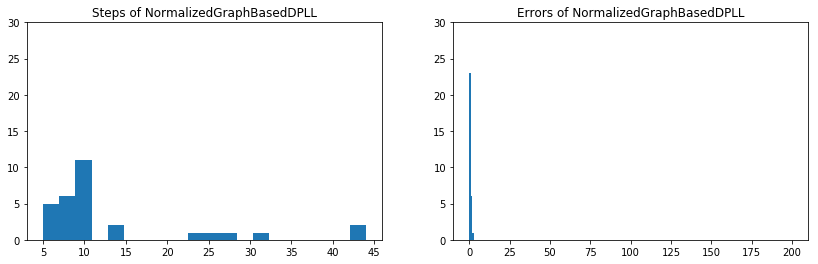

100%|██████████| 30/30 [00:00<00:00, 58.23it/s]


Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 19.93; stdev step: 14.34; avg error: 1.50; stdev error: 1.02


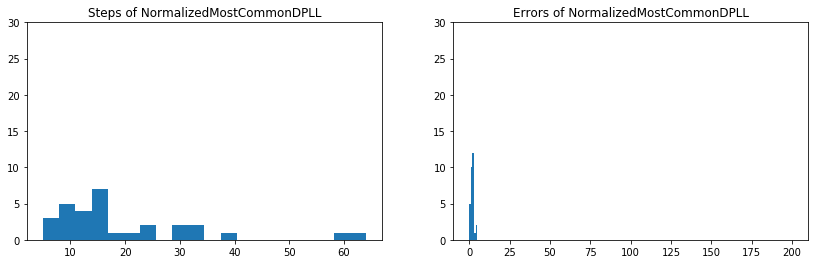

In [14]:
print_all(30, 200, 20)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:08<00:00,  1.06it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 11.00; stdev step: 7.38; avg error: 0.20; stdev error: 0.40


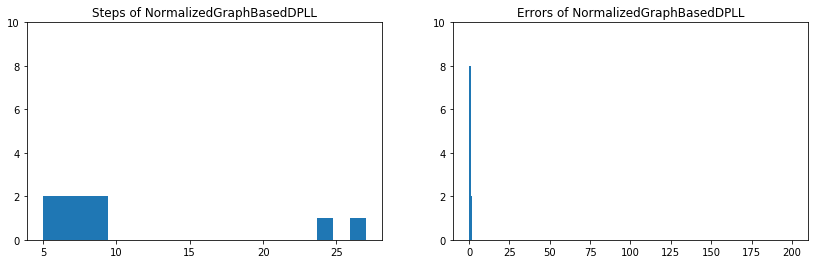

100%|██████████| 10/10 [00:00<00:00, 59.76it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 17.30; stdev step: 9.95; avg error: 1.50; stdev error: 1.20


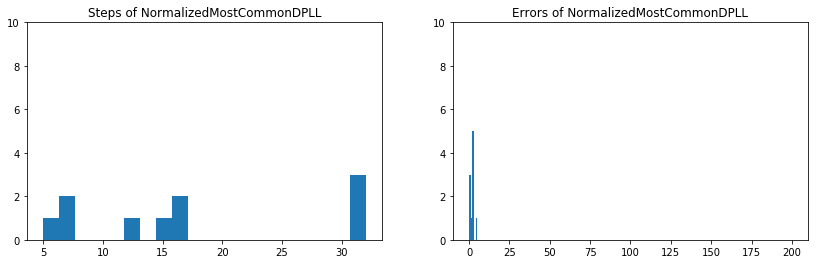

In [15]:
print_all(10, 200, 20)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:40<00:00,  1.99it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 5.77; stdev step: 2.64; avg error: 0.04; stdev error: 0.20


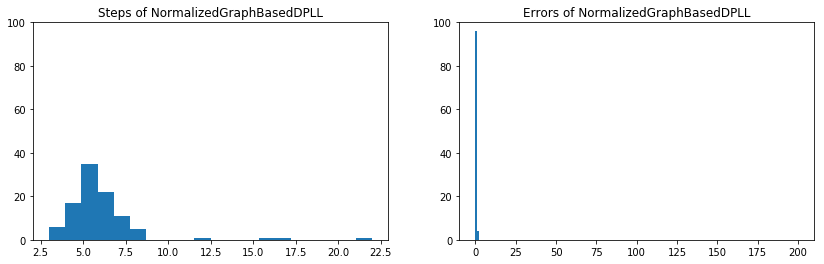

100%|██████████| 100/100 [00:00<00:00, 282.68it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.14; stdev step: 3.90; avg error: 0.86; stdev error: 0.72


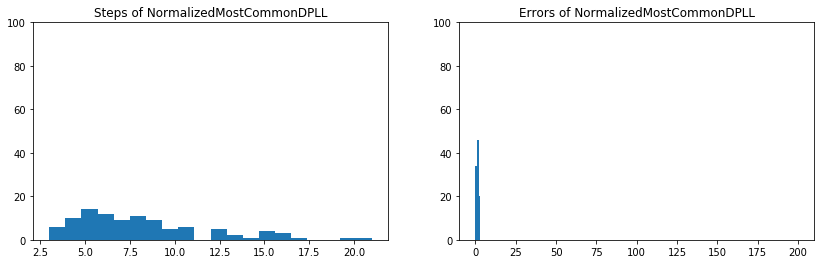

In [16]:
print_all(100, 200, 10)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:51<00:00,  2.14it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 6.58; stdev step: 3.71; avg error: 0.04; stdev error: 0.20


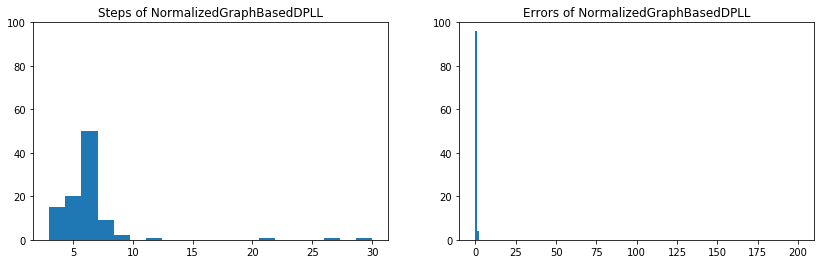

100%|██████████| 100/100 [00:00<00:00, 176.06it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.20; stdev step: 5.41; avg error: 1.06; stdev error: 0.87


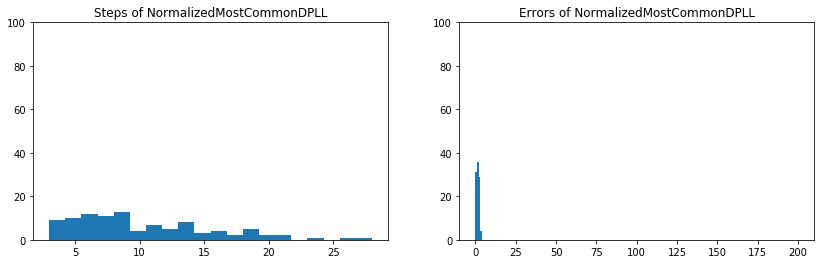

In [17]:
print_all(100, 200, 12)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [01:04<00:00,  1.82it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 7.89; stdev step: 4.57; avg error: 0.08; stdev error: 0.27


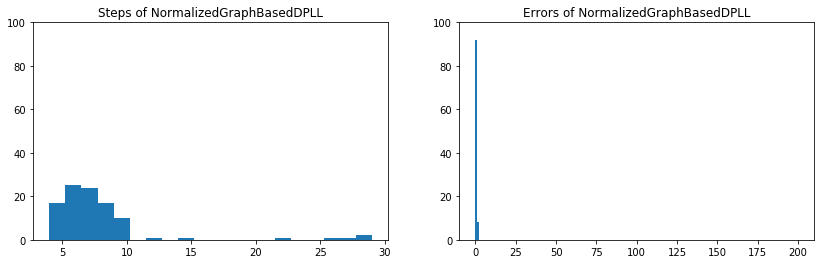

100%|██████████| 100/100 [00:00<00:00, 128.67it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 11.82; stdev step: 7.62; avg error: 1.14; stdev error: 0.88


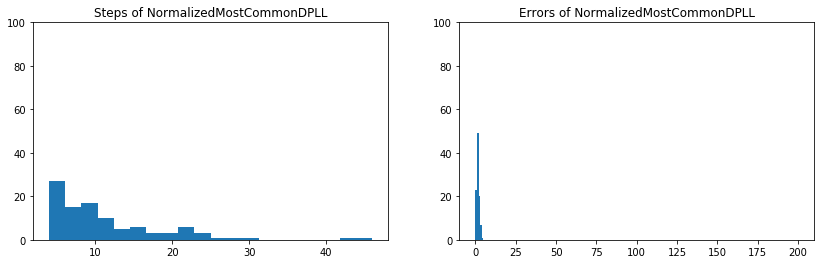

In [18]:
print_all(100, 200, 14)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [01:10<00:00,  1.46it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.13; stdev step: 5.28; avg error: 0.10; stdev error: 0.30


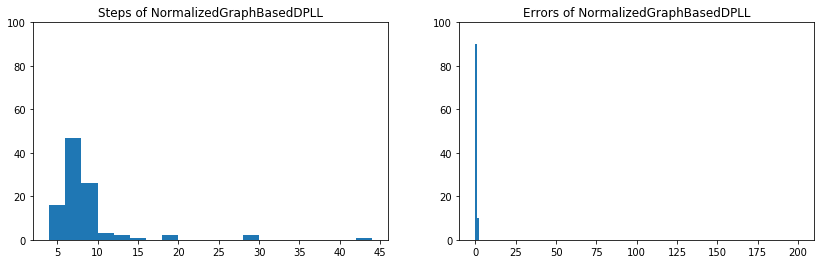

100%|██████████| 100/100 [00:01<00:00, 83.89it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 15.46; stdev step: 10.82; avg error: 1.23; stdev error: 0.91


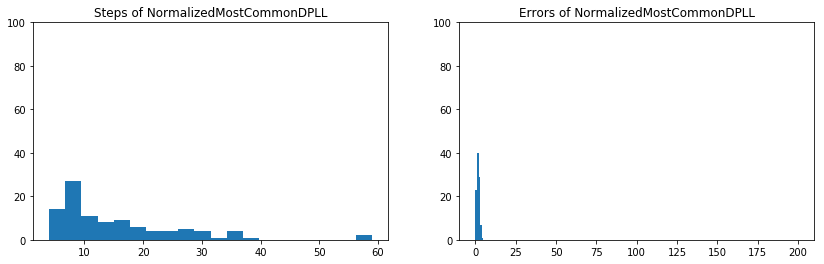

In [19]:
print_all(100, 200, 16)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [01:44<00:00,  1.23it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 12.29; stdev step: 9.84; avg error: 0.20; stdev error: 0.40


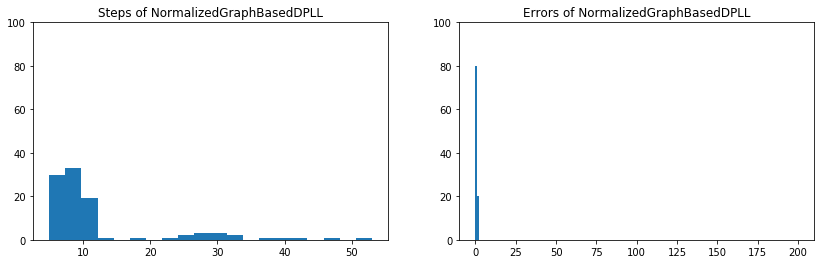

100%|██████████| 100/100 [00:01<00:00, 67.28it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 18.41; stdev step: 11.64; avg error: 1.41; stdev error: 0.91


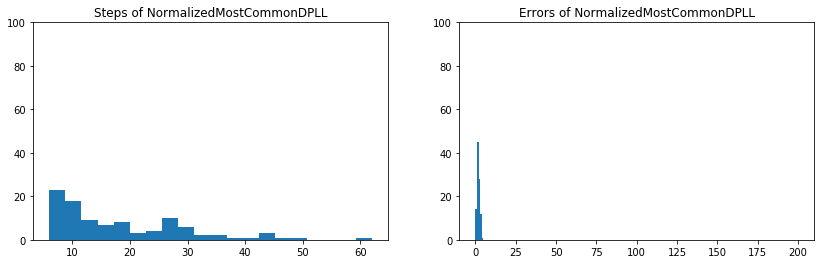

In [20]:
print_all(100, 200, 18)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [02:03<00:00,  2.05s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 14.02; stdev step: 12.83; avg error: 0.23; stdev error: 0.47


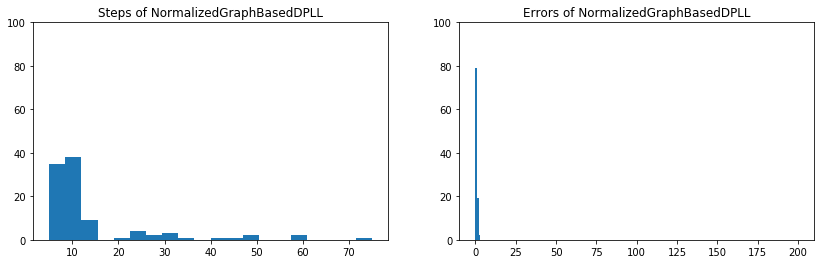

100%|██████████| 100/100 [00:02<00:00, 46.09it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 23.56; stdev step: 17.36; avg error: 1.57; stdev error: 1.05


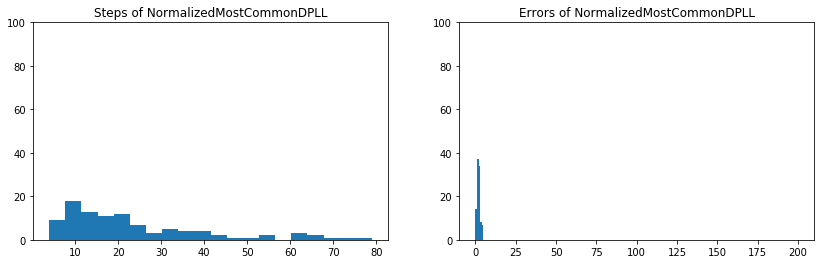

In [21]:
print_all(100, 200, 20)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [02:41<00:00,  1.34s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 15.40; stdev step: 17.02; avg error: 0.15; stdev error: 0.38


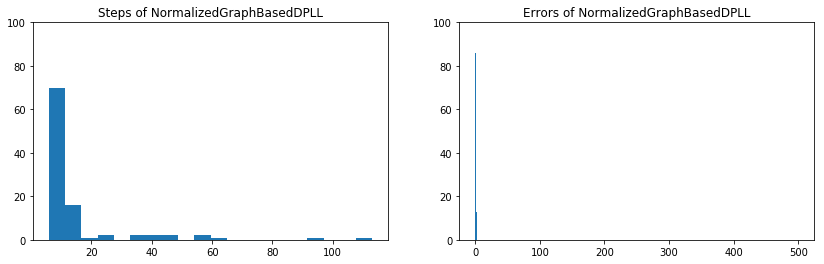

100%|██████████| 100/100 [00:04<00:00, 20.53it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 32.48; stdev step: 30.11; avg error: 1.63; stdev error: 1.14


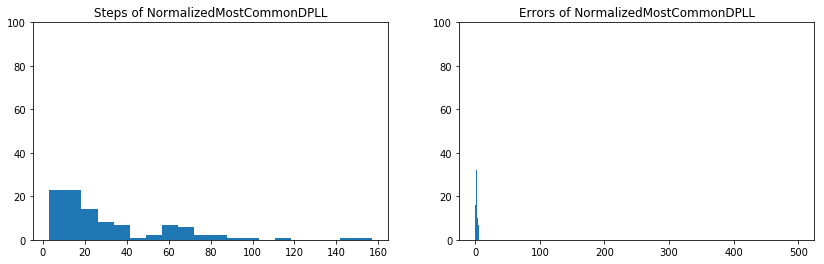

In [22]:
print_all(100, 500, 25, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [04:21<00:00,  2.96s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 24.34; stdev step: 35.44; avg error: 0.16; stdev error: 0.37


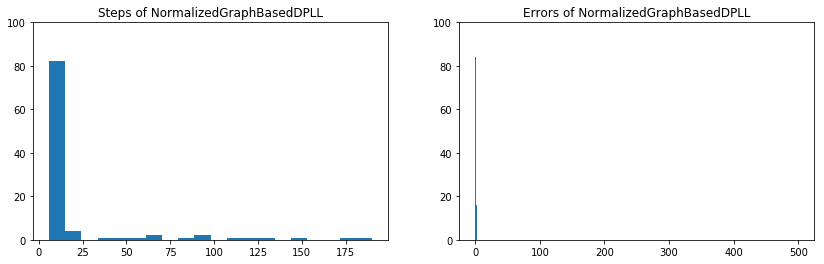

100%|██████████| 100/100 [00:10<00:00,  9.24it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 53.31; stdev step: 48.86; avg error: 2.03; stdev error: 1.19


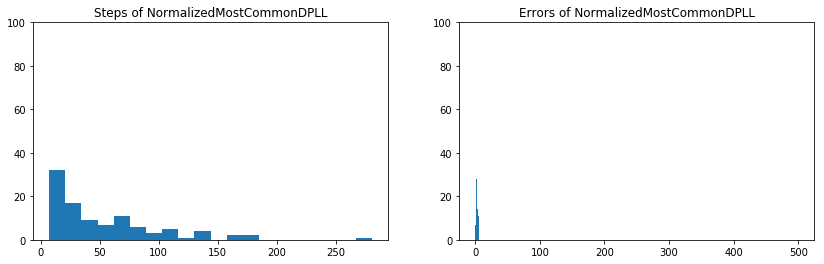

In [23]:
print_all(100, 500, 30, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [11:25<00:00,  4.81s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 61.45; stdev step: 113.49; avg error: 0.30; stdev error: 0.54


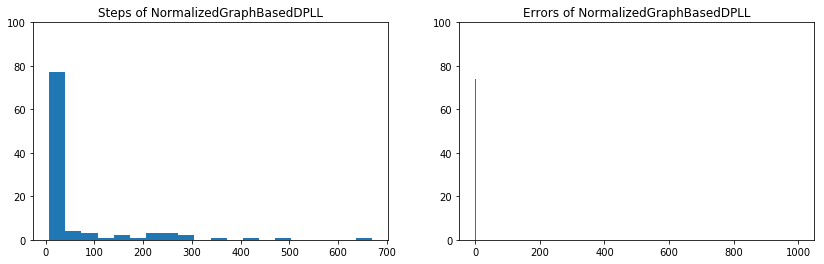

100%|██████████| 100/100 [00:58<00:00,  1.28it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 190.63; stdev step: 167.22; avg error: 2.65; stdev error: 1.32


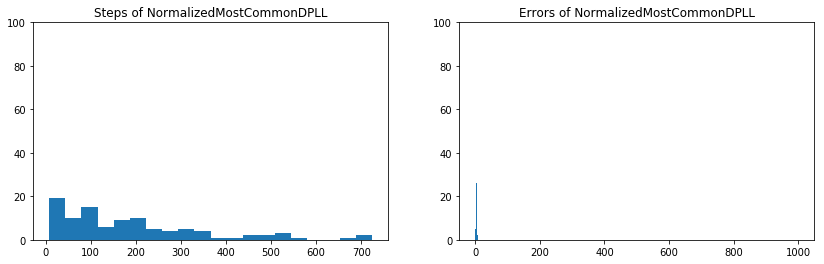

In [24]:
print_all(100, 1000, 40, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [30:25<00:00, 18.95s/it]


Within 1000 steps solved 97 problems out of 100
#Sats: 97; avg step: 126.11; stdev step: 201.88; avg error: 0.43; stdev error: 0.64


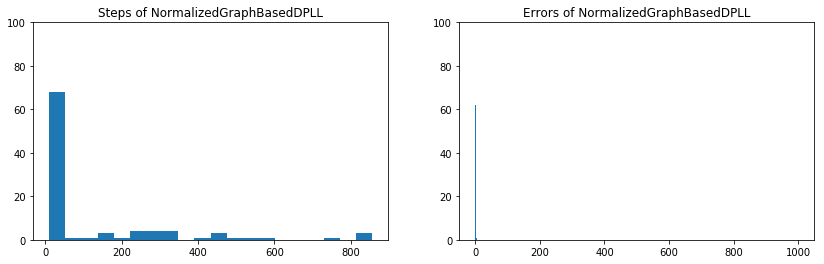

100%|██████████| 100/100 [03:26<00:00,  3.16s/it]


Within 1000 steps solved 85 problems out of 100
#Sats: 85; avg step: 376.07; stdev step: 300.93; avg error: 2.89; stdev error: 1.34


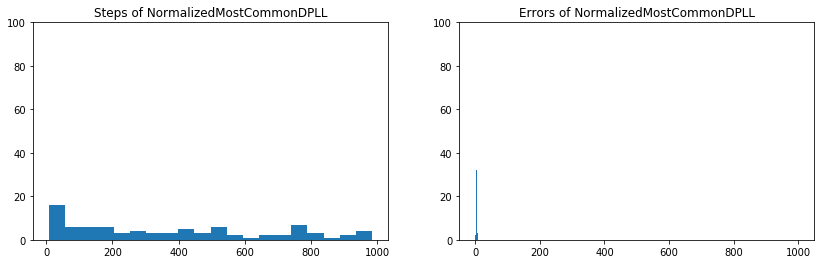

In [25]:
print_all(100, 1000, 50, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [1:36:18<00:00, 59.87s/it]


Within 1000 steps solved 69 problems out of 100
#Sats: 69; avg step: 152.80; stdev step: 241.27; avg error: 0.42; stdev error: 0.65


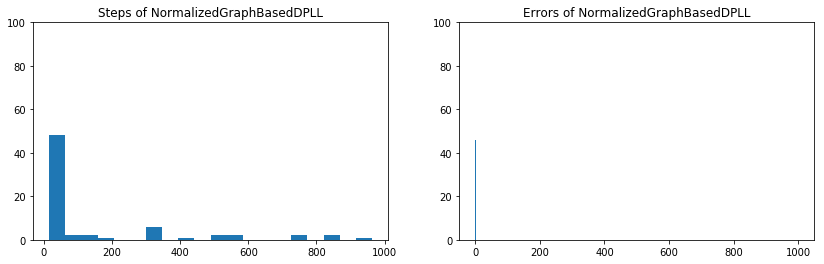

100%|██████████| 100/100 [10:19<00:00,  5.01s/it]


Within 1000 steps solved 26 problems out of 100
#Sats: 26; avg step: 505.96; stdev step: 332.60; avg error: 3.62; stdev error: 1.30


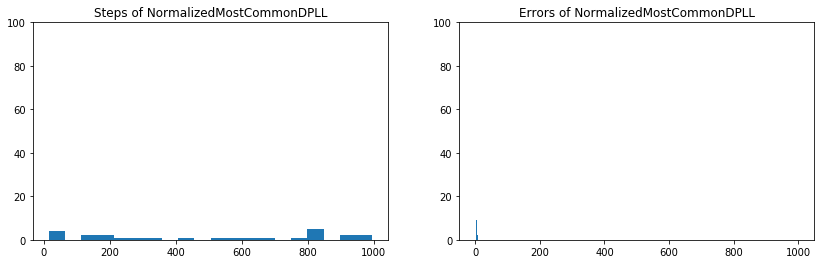

In [26]:
print_all(100, 1000, 70, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [2:38:27<00:00, 72.02s/it]


Within 1000 steps solved 50 problems out of 100
#Sats: 50; avg step: 119.64; stdev step: 193.52; avg error: 0.38; stdev error: 0.69


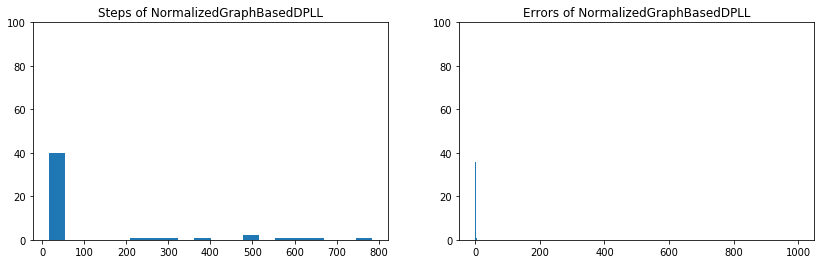

100%|██████████| 100/100 [17:00<00:00,  9.91s/it]


Within 1000 steps solved 7 problems out of 100
#Sats: 7; avg step: 355.86; stdev step: 257.68; avg error: 3.71; stdev error: 1.83


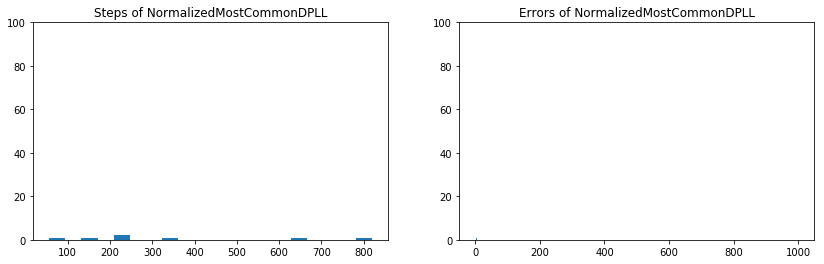

In [27]:
print_all(100, 1000, 90, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [3:37:25<00:00, 138.12s/it]


Within 1000 steps solved 25 problems out of 100
#Sats: 25; avg step: 48.68; stdev step: 42.89; avg error: 0.20; stdev error: 0.49


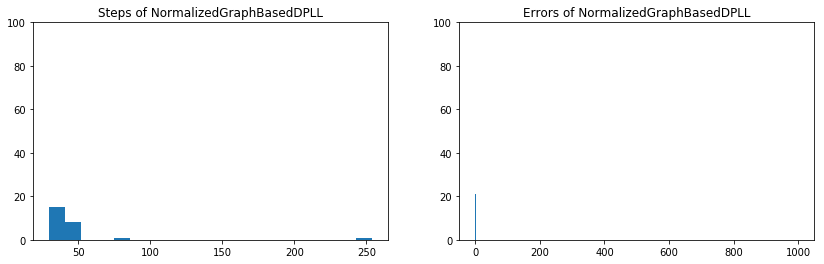

100%|██████████| 100/100 [17:54<00:00, 11.04s/it]


Within 1000 steps solved 2 problems out of 100
#Sats: 2; avg step: 489.50; stdev step: 436.50; avg error: 3.00; stdev error: 1.00


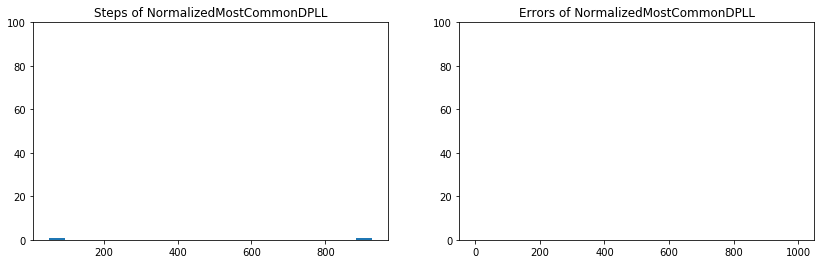

In [28]:
print_all(100, 1000, 110, light=True)